In [91]:
import numpy as np
from collections import defaultdict
import string
import heapq
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle

In [53]:
class Word2Vec:
    def __init__(self, corpus, emb_dim=100, window_size=5, learning_rate=0.025):
        self.corpus = corpus
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.vocab = list(set(self.corpus))
        self.word_to_index = {w: i for i, w in enumerate(self.vocab)}
        self.index_to_word = {i: w for i, w in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        self.W1 = np.random.uniform(-0.8, 0.8, (self.vocab_size, self.emb_dim))
        self.W2 = np.random.uniform(-0.8, 0.8, (self.emb_dim, self.vocab_size))

    def generate_training_data(self):
        training_data = []
        for i, word in enumerate(self.corpus):
            for j in range(max(0, i - self.window_size), i):
                training_data.append((word, self.corpus[j]))
            for j in range(i + 1, min(i + self.window_size + 1, len(self.corpus))):
                training_data.append((word, self.corpus[j]))
        return training_data

    def one_hot(self, index):
        one_hot_vec = np.zeros(self.vocab_size)
        one_hot_vec[index] = 1
        return one_hot_vec

    def train(self, epochs):
        training_data = self.generate_training_data()
        for epoch in range(epochs):
            self.loss = 0
            for w, c in training_data:
                x = self.one_hot(self.word_to_index[w])
                y = self.one_hot(self.word_to_index[c])
                h = np.dot(x, self.W1)
                u = np.dot(h, self.W2)
                y_pred = self.softmax(u)
                error = y - y_pred
                self.loss += np.sum(error ** 2)
                dW2 = np.outer(h, error)
                dW1 = np.outer(x, np.dot(self.W2, error))
                self.W2 += self.learning_rate * dW2
                self.W1 += self.learning_rate * dW1
            print("Epoch %d, loss: %.4f" % (epoch+1, self.loss))

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def get_embedding(self, word):
        return self.W1[self.word_to_index[word]]
    
    def get_similar_words(self, word, n=5):
        if word not in self.vocab:
            return f"{word} not in vocabulary"
        
        word_emb = self.get_embedding(word)
        scores = {}
        for w in self.vocab:
            if w != word:
                emb = self.get_embedding(w)
                scores[w] = np.dot(word_emb, emb) / (np.linalg.norm(word_emb) * np.linalg.norm(emb))
        
        top_n = heapq.nlargest(n, scores, key=scores.get)
        return top_n

In [28]:
def remove_punctuation(text):
    # Remove all punctuation from the text using the string module
    no_punct = text.translate(str.maketrans("", "", string.punctuation))
    return no_punct

with open("darija_corpus.txt", "r", encoding="utf-8") as f:
    corpus = f.read()
    corpus = remove_punctuation(corpus)

In [81]:
#corpus = corpus.split()
#model = Word2Vec(corpus, emb_dim=10, window_size=2, learning_rate=0.01)
model.learning_rate = 0.0001
model.train(epochs=500)

Epoch 1, loss: 1036.5328
Epoch 2, loss: 1036.5319
Epoch 3, loss: 1036.5311
Epoch 4, loss: 1036.5302
Epoch 5, loss: 1036.5293
Epoch 6, loss: 1036.5284
Epoch 7, loss: 1036.5275
Epoch 8, loss: 1036.5267
Epoch 9, loss: 1036.5258
Epoch 10, loss: 1036.5249
Epoch 11, loss: 1036.5240
Epoch 12, loss: 1036.5231
Epoch 13, loss: 1036.5223
Epoch 14, loss: 1036.5214
Epoch 15, loss: 1036.5205
Epoch 16, loss: 1036.5196
Epoch 17, loss: 1036.5187
Epoch 18, loss: 1036.5179
Epoch 19, loss: 1036.5170
Epoch 20, loss: 1036.5161
Epoch 21, loss: 1036.5152
Epoch 22, loss: 1036.5144
Epoch 23, loss: 1036.5135
Epoch 24, loss: 1036.5126
Epoch 25, loss: 1036.5117
Epoch 26, loss: 1036.5108
Epoch 27, loss: 1036.5100
Epoch 28, loss: 1036.5091
Epoch 29, loss: 1036.5082
Epoch 30, loss: 1036.5073
Epoch 31, loss: 1036.5065
Epoch 32, loss: 1036.5056
Epoch 33, loss: 1036.5047
Epoch 34, loss: 1036.5038
Epoch 35, loss: 1036.5030
Epoch 36, loss: 1036.5021
Epoch 37, loss: 1036.5012
Epoch 38, loss: 1036.5003
Epoch 39, loss: 1036.

Epoch 311, loss: 1036.2672
Epoch 312, loss: 1036.2663
Epoch 313, loss: 1036.2655
Epoch 314, loss: 1036.2647
Epoch 315, loss: 1036.2638
Epoch 316, loss: 1036.2630
Epoch 317, loss: 1036.2622
Epoch 318, loss: 1036.2613
Epoch 319, loss: 1036.2605
Epoch 320, loss: 1036.2597
Epoch 321, loss: 1036.2589
Epoch 322, loss: 1036.2580
Epoch 323, loss: 1036.2572
Epoch 324, loss: 1036.2564
Epoch 325, loss: 1036.2555
Epoch 326, loss: 1036.2547
Epoch 327, loss: 1036.2539
Epoch 328, loss: 1036.2530
Epoch 329, loss: 1036.2522
Epoch 330, loss: 1036.2514
Epoch 331, loss: 1036.2505
Epoch 332, loss: 1036.2497
Epoch 333, loss: 1036.2489
Epoch 334, loss: 1036.2481
Epoch 335, loss: 1036.2472
Epoch 336, loss: 1036.2464
Epoch 337, loss: 1036.2456
Epoch 338, loss: 1036.2447
Epoch 339, loss: 1036.2439
Epoch 340, loss: 1036.2431
Epoch 341, loss: 1036.2422
Epoch 342, loss: 1036.2414
Epoch 343, loss: 1036.2406
Epoch 344, loss: 1036.2398
Epoch 345, loss: 1036.2389
Epoch 346, loss: 1036.2381
Epoch 347, loss: 1036.2373
E

In [72]:
model.get_similar_words("nta")

['fach', 'chwy', 'store', 'doz', 'chambre']

In [57]:
sorted(model.corpus)

['1',
 '1',
 '14',
 '17hAnochi',
 '3ad',
 '3echtifl',
 '3la',
 '3lihom',
 '3ndi',
 '3ndi',
 '3ndiMmm',
 '3raftou',
 '7it',
 '7it',
 '7it',
 '7sen',
 '7ssen',
 '7ta',
 '9bel',
 '9ism',
 'Akid',
 'Arabic',
 'Darija',
 'Egyptian',
 'Gigi',
 'I',
 'I',
 'I',
 'Ill',
 'Maghribia',
 'Many',
 'Mwallfa',
 'P',
 'TanTan',
 'Unlike',
 'a',
 'a',
 'abidi',
 'accessible',
 'active',
 'aftakhirPS',
 'akhouya',
 'akhra',
 'all',
 'amana',
 'an',
 'ana',
 'ana',
 'anchof',
 'andir',
 'app',
 'apparently',
 'are',
 'at9ad',
 'atgol',
 'atl9a',
 'att',
 'awalan',
 'aysiftohalk',
 'b7al',
 'ba9i',
 'balya',
 'bch',
 'bch',
 'be',
 'be3da',
 'be3da',
 'because',
 'believe',
 'better',
 'bghit',
 'bghity',
 'bla',
 'blache',
 'blan',
 'bnisba',
 'book',
 'books',
 'books',
 'booksgha',
 'busy',
 'but',
 'but',
 'but',
 'but',
 'by',
 'bzzf',
 'canWach',
 'can’t',
 'chambre',
 'checkit',
 'chewwafa',
 'chi',
 'chi',
 'chkelA',
 'chwy',
 'compte',
 'compte',
 'consider',
 'd',
 'db',
 'des',
 'dik',
 'dima'

### Vizualization using PCA

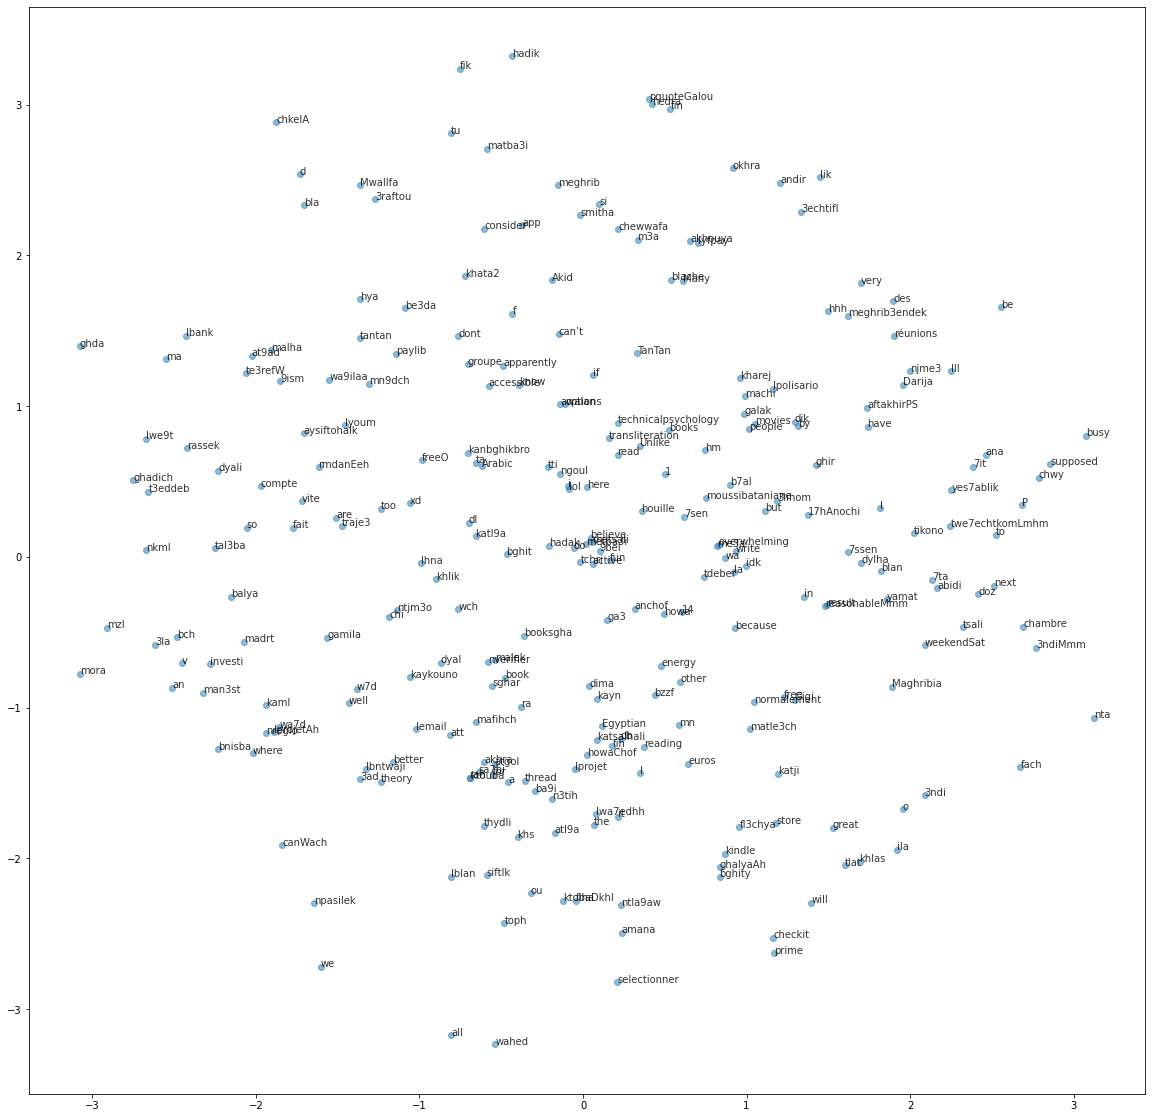

In [82]:
# Get the word vectors for a subset of the vocabulary
word_vectors = np.array([model.get_embedding(w) for w in model.vocab[:500]])

# Apply PCA to reduce the dimensionality of the word vectors
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)
plt.figure(figsize = (20,20))

# Plot the word vectors in 2D space
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], alpha=0.5)

# Label each point with its corresponding word
for i, word in enumerate(model.vocab[:500]):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]), alpha=0.8)

plt.show()


Cluster  1 :  ['lwe9t', 'dl', 'nkml', 'investi', '3ad', 'w7d', 'an', 'bch', 'kaml', 'nreglo']
Cluster  2 :  ['nta', 'fach', '3ndi', 'o', 'chwy', 'doz', '7ta', 'blan', 'next', 'tsali', 'weekendSat', 'chambre', 'khlas', '3ndiMmm']
Cluster  3 :  ['atgol', 'anchof', 'technicalpsychology', 'overwhelming', 'twe7echtkomLmhm', 'rmdanEeh', 'dima', 'abidi', 'other', '7sen']
Cluster  4 :  ['vite', 'fait', 'dyali', 'aysiftohalk', 'compte', 'at9ad']
Cluster  5 :  ['Ill', 'idk', 'reasonableMmm', 'but', 'kanbghikbro', 'be', 'result', 'dylha']
Cluster  6 :  ['busy', 'I', 'hm', 'write', 'very', 'to', 'supposed', 'have', 'because', 'transliteration']
Cluster  7 :  ['hya', 'lbank', 'paylib', 'smitha', 'lyfpay', '9ism', 'd', 'hedra', 'hadik']
Cluster  8 :  ['euros', 'lblan', 'kaykouno', 'katl9a', 'ktouba', 'sghar', 'chi', 'gamila', '3la', '14']
Cluster  9 :  ['ghalyaAh', 'great', 'tlat', 'lprojet', 'ila', 'katji', 'bghity', 'ntla9aw', 'will', 'fl3chya', 'lwa7edhh', 'it', 'khs', 'n3tih']
Cluster  10 :  ['t

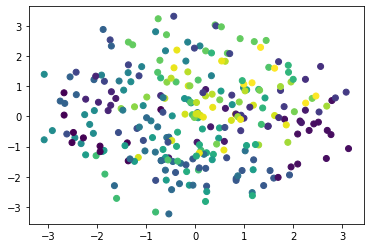

In [90]:
# Get the word embeddings from the model
word_embeddings = model.W1

# Use PCA to reduce the dimensionality of the embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(word_embeddings)

# Define the number of clusters
num_clusters = 30

# Use K-Means clustering to cluster the embeddings
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(word_embeddings)

# Get the cluster assignments for each word
cluster_assignments = kmeans.labels_

# Print the words in each cluster
for i in range(num_clusters):
    cluster_words = [word for j, word in enumerate(model.vocab) if cluster_assignments[j] == i]
    print("Cluster ", i+1, ": ", cluster_words)

# Visualize the clusters in 2D space
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_assignments)
plt.show()

In [92]:
with open('darija2vec.pkl', 'wb') as f:
    pickle.dump(model, f)